In [16]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

In [17]:
input_shape = (224,224,3)
number_anchor = 9
anchor_ratios = [(1,1), (1,2), (2,1), (2,2), (2,4), (4,2), (4,4), (4,8), (8,4)]
anchor_default_size = 28

In [18]:
train_datasets_path = 'train2014/'
annotations_path = 'annotations/'

In [19]:
annotations_json_path = annotations_path + 'instances_train2014.json'
annotations_json = json.load(open(annotations_json_path,'r'))

In [20]:
label_id_dict ={annotations_json['categories'][i]['id']:i for i in range(len(annotations_json['categories']))}

In [21]:
def get_label_name(category_id):
    return annotations_json['categories'][label_id_dict[annotation['category_id']]]['name']

In [22]:
datasets = {}

def load_images(size):
    global datasets
    datasets = {}
    for i, image_info in enumerate(annotations_json['images'][:size]):
        img_name = train_datasets_path + image_info['file_name']
        print('{} % ,loading {}'.format((i+1)*100//size,img_name))
        
        img = cv2.imread(img_name)
        img, resize_ratio = resize_by_padding(img,input_shape[1],input_shape[0])
        
        data = {'img':img,
                'resize_ratio':resize_ratio,
                'index':i,
                'original_resolution':(image_info['height'], image_info['width'])
               }
        datasets[image_info['id']] = data

In [23]:
def resize_by_padding(img,net_width,net_height):
    img_h,img_w = img.shape[:2]

    if img_h > img_w:
        new_h = int(net_height)
        new_w = int(img_w * net_height / img_h)
    else:
        new_w = int(net_width)
        new_h = int(img_h * net_width / img_w)

    resize_ratio = (new_w / img_w, new_h / img_h)
    
    img = img[:,:,::-1]
    img = img/255.
    resized = cv2.resize(img,(new_w,new_h))
    base_img = np.ones((net_height,net_width,3)) * 0.5
    base_img[(net_height-new_h)//2 : (net_height+new_h)//2,(net_width-new_w)//2 : (net_width+new_w)//2,:] = resized
    
    resize_offset = ((net_width - new_w)//2, (net_height - new_h)//2)
    return base_img, (resize_ratio, resize_offset)

In [31]:
def convert_resized_bbox(bbox,resize_ratio):
    ratio, offset = resize_ratio
    return [bbox[0]*ratio[0]+offset[0], bbox[1]*ratio[1]+offset[1], bbox[2]*ratio[0], bbox[3]*ratio[1]]
def convert_bbox_to_ratio(bbox,img_shape):
    return [bbox[0]/img_shape[1], bbox[1]/img_shape[0], bbox[2]/img_shape[1], bbox[3]/img_shape[0]]
def convert_cocobbox_to_anchorbbox(bbox):
    return [bbox[0]+(bbox[2]//2), bbox[1]+(bbox[3]//2), bbox[2], bbox[3]]

In [100]:
def draw_box(img,bbox_ratio,color):
    print(bbox_ratio)
    bbox = np.copy(bbox_ratio)
    bbox[[0,2]] *= input_shape[1]
    bbox[[1,3]] *= input_shape[0]
    coor = [bbox[0] - bbox[2]/2, bbox[1] - bbox[3] / 2, bbox[0] + bbox[2]/2, bbox[1] + bbox[3] / 2]
    coor = [int(x) for x in coor]
    coor = tuple(coor)
    print(coor)
    return cv2.rectangle(img,coor[:2],coor[2:],color,1)

In [81]:
base_anchor = np.array([
    anchor_default_size/2, anchor_default_size/2, 
    anchor_default_size, anchor_default_size
])

def generate_anchor_bbox():
    anchors = []
    for y_box in range(net_height):
        for x_box in range(net_width):
            tmp_anchor = np.copy(base_anchor)
            tmp_anchor[:2] += x_box*stride_size, y_box*stride_size
            tmp_anchors = []
            for ratio in anchor_ratios:
                tmp = np.copy(tmp_anchor)
                tmp[2:] *= ratio
                tmp = convert_bbox_to_ratio(tmp, input_shape[:2])
                tmp_anchors.append(tmp)
            tmp_anchors = np.array(tmp_anchors)
            anchors.append(tmp_anchors)
    anchors = np.array(anchors)
    return anchors

In [79]:
net_height, net_width = 28, 28
stride_size = input_shape[0] // net_height
cls = np.empty((len(datasets), net_height, net_width, number_anchor*2))
rgs = np.empty((len(datasets), net_height, net_width, number_anchor*4))
def initilize_output():
    global datasets
    for i, annotation in enumerate(annotations_json['annotations']):
        try:
            datasets[annotation['image_id']]
        except KeyError:
            continue
        class_id = annotation['category_id']
        truth_bbox = annotation['bbox']
        truth_bbox = convert_cocobbox_to_anchorbbox(truth_bbox)

        datasets[annotation['image_id']]['anchors'] = generate_anchor_bbox()

        truth_bbox = convert_resized_bbox(truth_bbox, datasets[annotation['image_id']]['resize_ratio']) 
        truth_bbox = convert_bbox_to_ratio(truth_bbox, input_shape[:2])
        datasets[annotation['image_id']]['truth_bbox'] = truth_bbox
#     img = images[images_dict[annotation['image_id']]]
#     img = draw_box(img,truth_bbox,(0,255,0))
#     images[images_dict[annotation['image_id']]] = img
#     plt.imshow(img)
#     label_id, label_name = annotation['category_id'], get_label_name(annotation['category_id'])
#     print(label_id, label_name)

In [28]:
load_images(10)

10 % ,loading train2014/COCO_train2014_000000057870.jpg
20 % ,loading train2014/COCO_train2014_000000384029.jpg
30 % ,loading train2014/COCO_train2014_000000222016.jpg
40 % ,loading train2014/COCO_train2014_000000520950.jpg
50 % ,loading train2014/COCO_train2014_000000069675.jpg
60 % ,loading train2014/COCO_train2014_000000547471.jpg
70 % ,loading train2014/COCO_train2014_000000122688.jpg
80 % ,loading train2014/COCO_train2014_000000392136.jpg
90 % ,loading train2014/COCO_train2014_000000398494.jpg
100 % ,loading train2014/COCO_train2014_000000090570.jpg


In [82]:
initilize_output()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['truth_bbox', 'anchors', 'original_resolution', 'index', 'resize_ratio', 'img'])
[0.13392857 0.8125     0.125      0.125     ]
(16, 168, 44, 196)
[0.13392857 0.8125     0.125      0.25      ]
(16, 154, 44, 210)
[0.13392857 0.8125     0.25       0.125     ]
(2, 168, 58, 196)
[0.13392857 0.8125     0.25       0.25      ]
(2, 154, 58, 210)
[0.13392857 0.8125     0.25       0.5       ]
(2, 126, 58, 238)
[0.13392857 0.8125     0.5        0.25      ]
(-26, 154, 86, 210)
[0.13392857 0.8125     0.5        0.5       ]
(-26, 126, 86, 238)
[0.13392857 0.8125     0.5        1.        ]
(-26, 70, 86, 294)
[0.13392857 0.8125     1.         0.5       ]
(-82, 126, 142, 238)


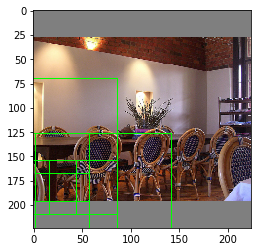

In [103]:
data = datasets[57870]
img = np.copy(data['img'])
for bbox in data['anchors'][590][:]:
    img = draw_box(img,bbox,(0,255,0))
plt.imshow(img)

In [21]:
annotation.keys()

dict_keys(['image_id', 'id', 'iscrowd', 'category_id', 'area', 'bbox', 'segmentation'])

In [24]:
annotations_json['annotations'][0].keys()

dict_keys(['category_id', 'id', 'iscrowd', 'segmentation', 'area', 'bbox', 'image_id'])

In [219]:
annotations_json['images'][0], annotations_json['annotations'][1]

({'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'date_captured': '2013-11-14 16:28:13',
  'file_name': 'COCO_train2014_000000057870.jpg',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'height': 480,
  'id': 57870,
  'license': 5,
  'width': 640},
 {'area': 421.47274999999996,
  'bbox': [85.939, 100.8595, 14.049, 6.6850000000000005],
  'category_id': 58,
  'id': 89,
  'image_id': 50518,
  'iscrowd': 0,
  'segmentation': [[252.46,
    208.17,
    267.96,
    210.11,
    280.14,
    213.98,
    285.68,
    221.45,
    279.59,
    227.27,
    270.73,
    223.12,
    256.61,
    218.69,
    253.02,
    217.3,
    248.03,
    220.07,
    245.54,
    215.92,
    245.82,
    209.55,
    249.69,
    208.45]]})